In [27]:
import numpy as np
import pandas as pd
import scipy

In [28]:
! ls

gaits.csv            reward_log.csv
log_trajectories.csv walk_analyser.ipynb


In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline

def draw_feet_graph(feet_data, feet_names, feet_colors, delta=0.2, max_length=500, graph_label=None):
    foot_count = len(feet_names)
    yspan = foot_count
    yplaces = [.5 + i for i in range(yspan)]
    ylabels = feet_names

    fig = plt.figure(figsize=(10, 3), dpi=100)
    ax = fig.add_subplot(111)
    ax.set_yticks(yplaces)
    ax.set_yticklabels(ylabels)
    ax.set_ylim((0, yspan))
    ax.set_xlim((0, max_length))
    if graph_label is not None:
        ax.set_title(graph_label)

    xmin, xmax = ax.get_xlim()
#     ax.hlines(range(1, yspan), xmin, xmax)
    time_step = 0
    vlines = []
    main_foot_curr_contact = False
    main_foot_last_contact = False
    
    for contacts in feet_data:
        if time_step > max_length:
            break
        for i in range(foot_count):
            if contacts[i] < 0.5:
                continue
            start, end = time_step, time_step + 1
            pos = yplaces[i]
            ax.add_patch(patches.Rectangle((start, pos - delta / 2.0), end - start, delta, color=feet_colors[i]))
            
        main_foot_curr_contact = True if contacts[0] > 0.5 else False
        if main_foot_curr_contact is True and main_foot_last_contact is False:
            vlines.append(time_step)
        main_foot_last_contact = main_foot_curr_contact
        time_step += 1
        
    for x in vlines:
        ax.axvline(x,0,1, lw=0.5, color=feet_colors[0])
#         print(x)
    fig.canvas.draw()
    
    return vlines

### График контактов получившейся походки 

In [32]:
# читаем лог контактов с поверхностью
df = pd.read_csv('./log_trajectories.csv')
walk_data = df.loc[:, "obs_32":"obs_37"]
walk_data = walk_data.applymap(lambda x: 0 if x < 0 else 1)
# walk_data.head(5)
walk_data = walk_data.values
# walk_data = walk_data[:,idx]

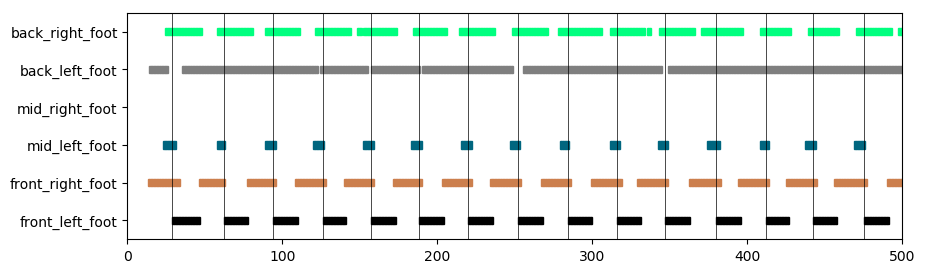

In [102]:
foot_colors = ['#000000', '#cc7f4d', '#00667f', '#ff667f', '#7f7f7f', '#00ff7f']
foot_list = ['front_left_foot', 'front_right_foot', 'mid_left_foot', 'mid_right_foot', 'back_left_foot', 'back_right_foot']
vlines = draw_feet_graph(walk_data, foot_list, foot_colors)

Режу походку на цикы по front_left_foot. todo: выводить информацию о параметрах обучения: имя целевой походки, количество эпизодов, использовавшиеся rewardы и их веса (если есть) и дату-время обучения. 

### График контактов целевой походки 

In [35]:
# модели походок в терминологии Лапшина
gdf = pd.read_csv('./gaits.csv')
gaits = gdf.set_index('gait_name').T.to_dict()
gdf.head(5)

,gait_name,beta,phi2,phi3,phi4,phi5,phi6
0,galop,0.66,0.00,0.66,0.66,0.33,0.33
1,triple,0.50,0.50,0.50,0.00,0.00,0.50
2,sequence,0.83,0.16,0.33,0.66,0.83,0.50


In [36]:
def generate_points(d, T):
    feet_data = np.zeros((T,6))
    d["phi1"] = 0
    for i in range(6):
        start_contact = int(T * d["phi"+str(i+1)]) 
        end_contact = int(T * ((d['beta'] + d["phi"+str(i+1)]) % 1))
        if start_contact > end_contact:
#             print("revert")
            for j in range(0, end_contact, 1):
                feet_data[j,i] = 1
            for j in range(end_contact, start_contact, 1):
                feet_data[j,i] = 0
            for j in range(start_contact, T, 1):
                feet_data[j,i] = 1
        else:
            for j in range(start_contact, end_contact, 1):
                feet_data[j,i] = 1
#         print(start_contact, end_contact)
    return feet_data


def draw_gait(d, T=60, cycles=5):
    # сгенерируем точки и отрисуем через draw_feet_graph
    feet_data = generate_points(d, T)
    fd = feet_data
    for i in range(cycles):
        fd = np.concatenate((fd,feet_data))
    draw_feet_graph(fd, new_foot_list, new_foot_colors)

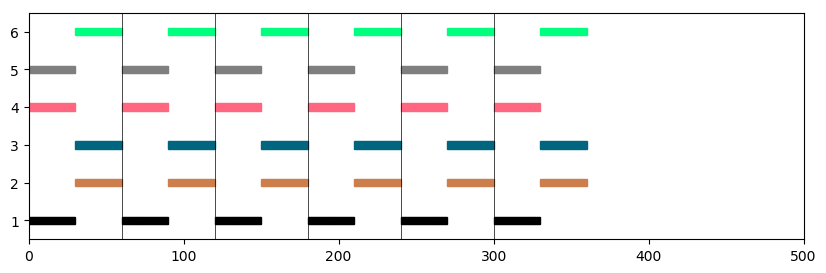

In [37]:
draw_gait(gaits["triple"])

### Сравнение походок

In [39]:
# генерируем точки для походки в масштабе траектории из лога
def generate_scaled_gait(gait, trajectory_log):
    contact_times = []
    main_foot_curr_contact = False
    main_foot_last_contact = False
    time_step = 0
    
    for contacts in trajectory_log:
        main_foot_curr_contact = True if contacts[0] > 0.5 else False
        if main_foot_curr_contact is True and main_foot_last_contact is False:
            contact_times.append(time_step)
        main_foot_last_contact = main_foot_curr_contact
        time_step += 1
        
    scaled_gait = None
    last_contact_time = 0
    for contact_time in contact_times:
        feet_data = generate_points(gait, contact_time - last_contact_time)
        if scaled_gait is None:
            scaled_gait = feet_data
        else:
            scaled_gait = np.concatenate((scaled_gait,feet_data))
        last_contact_time = contact_time
    # последний цикл походки
    feet_data = generate_points(gait, trajectory_log.shape[0] - last_contact_time)
    scaled_gait = np.concatenate((scaled_gait,feet_data))
    return scaled_gait


def get_feet_error(gait, trajectory_log):
    scaled_gait = generate_scaled_gait(gait, trajectory_log)
    assert(trajectory_log.shape == scaled_gait.shape)
    errors = []
    for i in range(6):
        error = 0
        for j in range(trajectory_log.shape[0]):
            if trajectory_log[j,i] != scaled_gait[j,i]:
                error += 1
        errors.append(error)
    return errors  



In [98]:
def print_error(gait_name):
    feet_errors = get_feet_error(gaits[gait_name], trajectory_log)
    print("contact errors for {} walk\n{}\nsum: {}\naccuracy: {:.1f}%".format(gait_name, feet_errors, sum(feet_errors),(1 - sum(feet_errors)/6000)*100))
    scaled_gait = generate_scaled_gait(gaits[gait_name], walk_data)
    draw_feet_graph(walk_data, foot_list, foot_colors, graph_label="модель", max_length=150)
    draw_feet_graph(scaled_gait,foot_list, foot_colors, graph_label="целевая походка",    max_length=150)

errors - массив "промахов" в походку для каждой ноги

accuracy - процент попаданий 

contact errors for triple walk
[263, 405, 332, 479, 317, 318]
sum: 2114
accuracy: 64.8%


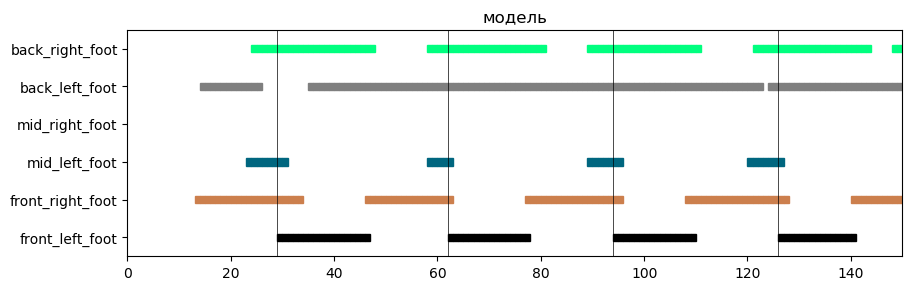

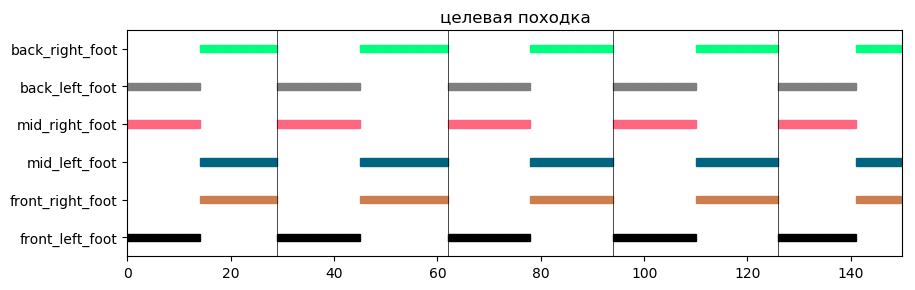

In [99]:
print_error("triple")

### Графики reward

In [76]:
rdf = pd.read_csv('./reward_log.csv')
reward_log = rdf.to_dict('list')
rdf.head(5)

,alive,progress,electricity_cost,joints_at_limit_cost,feet_collision_cost,gait_reward
0,1,-0.002081,-0.687132,-1.2,0,-0.3
1,1,-0.011762,-0.898344,-1.2,0,-0.3
2,1,-0.030669,-0.765197,-1.2,0,-0.3
3,1,-0.047877,-0.555405,-0.8,0,-0.3
4,1,-0.061390,-0.515921,-0.8,0,-0.3


In [111]:
def draw_reward_graph(reward_log, start_from=0, end_at=500):
    fig = plt.figure(figsize=(12, 5), dpi=100)
    ax = fig.add_subplot(111)
    x = [i for i in range(start_from,end_at,1)]
    ax.plot(x, reward_log['progress'][start_from:end_at], '-g', label='progress')
    ax.plot(x, reward_log['electricity_cost'][start_from:end_at], '-b', label='electricity_cost')
    ax.plot(x, reward_log['joints_at_limit_cost'][start_from:end_at], '-r', label='joints_at_limit_cost')
    ax.plot(x, reward_log['feet_collision_cost'][start_from:end_at], '-y', label='feet_collision_cost')
    ax.plot(x, reward_log['gait_reward'][start_from:end_at], '-c', label='gait_reward')
    for x in vlines:
        if x >= start_from and x < end_at:
            ax.axvline(x,0,1, lw=0.5, color='#000000')
    ax.set_xlabel("step")
    ax.set_ylabel("reward")
    ax.legend(loc='upper right')

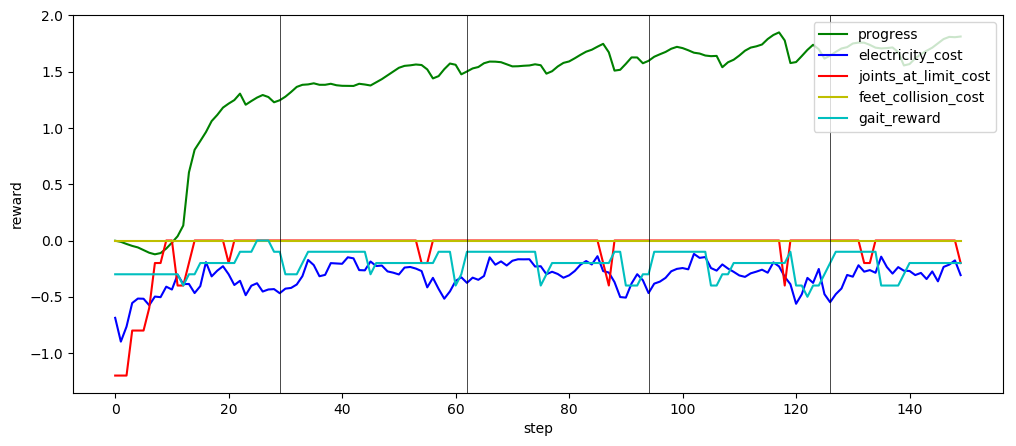

In [113]:
draw_reward_graph(reward_log,0,150)

In [ ]:
попробовать поучить не для всех reward, оставить только progress и gait